In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################


這邊參考的主要來源是[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/windy_grid_world.py)

Example 6.7: Maximization Bias Example

![](https://i.imgur.com/eIvX9qL.png)
Figure 6.5：在一個簡單的episodic MDP上比較Q-learning與Double Q-learning(如插圖所示)。Q-learning一開始學習到採用left的頻率比right還要來的多次， 而且機率明顯高過於$\epsilon=0.1$所強制的最小5%的機率。相比之下，Double Q-learning就不受maximization bias的影響。這些資料是執行10,000次的平均。初始的action-value為0。Any ties in $\epsilon$-greedy action selection were broken randomly. (這句真的不會翻，不過意思大致就是，當你遇到兩個action的機率一致的時候就隨機選一個吧。)

Figure 6.5那個小小的MDP插圖提供簡單的範例，說明maximization bias如何對TD control algorithms造成傷害：
1. 有一個MPD，它有兩個non-terminal states $A$、$B$
2. episode都是從$A$開始
3. 兩個actions，左、右
4. 如果選擇右，那就會馬上進入終止狀態(terminal state)，然後reward、return都是0
5. 如果選擇左，那就轉移至$B$，然後reward也是0，然後接續會有很多actions都會導致立即終止，然後會從一個均值為-0.1、方差為1.0的均勻分佈中得到一個reward

好，現在我們知道，對於任意一個trajectory是從左這個action開始的expected return都是-0.1，這樣子，你在$A$選擇左這個action就是錯的。

儘管如此，我們的control methods也許會喜歡"左"這個action，因為maximization bias讓$B$明顯的有positive value。所以你看一下上面的圖也不難發現，用著$\epsilon-$greedy的Q-learning一開始的學習是非常愛好"左"這個action。即使在漸近線處，選擇"左"的機率也還是比我們參數設置($\epsilon=0.1, \alpha=0.1, \gamma=1$)的最佳值高了大約5%。

載入需求套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

根據說明，會有兩個nonterminal states

In [3]:
STATE_A = 0
STATE_B = 1
STATE_TERMINAL = 2

根據說明，每一個episode都是從A開始

In [4]:
START_STATE = STATE_A

定義環境參數

In [5]:
EPSILON = 0.1
STEP_SIZE = 0.1
DISCOUNT_RATE = 1.0

定義STATE A的action space

In [6]:
ACTION_A_LEFT = 1
ACTION_A_RIGHT = 0

定義B的action space，根據說明，進入B之後你有超級多個actions給你選擇

In [7]:
ACTION_B = range(0, 10)

完整的action space

In [8]:
ACTION_SPACE = [[ACTION_A_RIGHT, ACTION_A_LEFT], ACTION_B]
ACTION_SPACE

[[0, 1], range(0, 10)]

初始化Q values，根據說明，全部初始化為0，多一個是用來記錄terminal state

In [9]:
INIT_Q = [np.zeros(2), np.zeros(len(ACTION_B)), np.zeros(1)]
INIT_Q

[array([0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.])]

狀態的轉移，如果是state A的話，那就會是往右，也就是terminal state，或是往左，也就是進入B，這要搭配上面設置的action。如果是B的話就會是好多個選擇，但是都還是會進入terminal state

In [10]:
TRANSITION = [[STATE_TERMINAL, STATE_B], [STATE_TERMINAL] * len(ACTION_B)]
TRANSITION

[[2, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]

定義一個選擇action的函數

In [11]:
def select_action(q_values, state):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTION_SPACE[state])
    else:
        _values = q_values[state]
        return np.random.choice([_action for _action, _value in enumerate(_values) if _value == np.max(_values)])

根據說明，進入state B之後，就會從均值為-0.1、方差為1的均勻分佈中得到一個reward，也就是在這邊會產生positive bias

In [12]:
def get_normal_reward(state, action):
    if state == STATE_A:
        return 0
    return np.random.normal(-0.1, 1)

In [13]:
get_normal_reward(1, 2)

1.3850611273429807

In [25]:
get_normal_reward(0, 2)

0

現在讓我們來定義learning algorithm

下面給出完整的演算法做為參考：  
![](https://i.imgur.com/lZFOlUq.png)

In [14]:
def q_learning(q1, q2=None):
    """Q-learning
    如果存在q2那就使用double q learning
    """
    state = START_STATE
    # 因為我們要跟著範例確認在state A的時候left被執行幾次，所以這邊要設個參數來記錄
    action_left_count = 0
    while state != STATE_TERMINAL:
        # 如果不是double q，那就直接由q1取出一個action
        # 如果是，那就兩個value function加總起來做選擇
        if q2 is None:
            action = select_action(q1, state)
        else:
            action = select_action([_q1 + _q2 for _q1, _q2 in zip(q1, q2)], state)
        
        if state == STATE_A and action == ACTION_A_LEFT:
            action_left_count += 1
        # 如果state是A那reward就是0，不然就是從normal distribution中取得reward
        reward = get_normal_reward(state, action)
        next_state = TRANSITION[state][action]
        
        if q2 is None:
            active_q = q1
            target = np.max(active_q[next_state])
        else:
            # 如果是double q learning，那就50/50的機率
            if np.random.binomial(1, 0.5) == 1:
                active_q = q1
                target_q = q2
            else:
                active_q = q2
                target_q = q1
                
            # 根據公式，我們會從action q中取得最大value的那個action
            best_action = np.random.choice([action_ for action_, value_ in enumerate(active_q[next_state]) if value_ == np.max(active_q[next_state])])
            # 再用target q來評估這個action有多好
            target = target_q[next_state][best_action]
        
        # 更新
        active_q[state][action] += STEP_SIZE * (
            reward + DISCOUNT_RATE * target - active_q[state][action]
        )
        state = next_state
    return action_left_count

現在我們可以來試著執行了

首先定義執行次數

In [15]:
episodes = 300
runs = 1000

設置參數來記錄在state A執行left的次數

In [16]:
left_counts_q = np.zeros((runs, episodes))
left_counts_double_q = np.zeros((runs, episodes))

執行

In [19]:
for run in tqdm(range(runs)):
    q1 = copy.deepcopy(INIT_Q)
    q2 = copy.deepcopy(INIT_Q)
    q3 = copy.deepcopy(INIT_Q)
    
    for episode in range(episodes):
        left_counts_q[run, episode] = q_learning(q1)
        left_counts_double_q[run, episode] = q_learning(q2, q3)

100%|██████████| 1000/1000 [00:44<00:00, 22.41it/s]


計算均值

In [20]:
left_counts_q = left_counts_q.mean(axis=0)
left_counts_double_q = left_counts_double_q.mean(axis=0)

繪圖

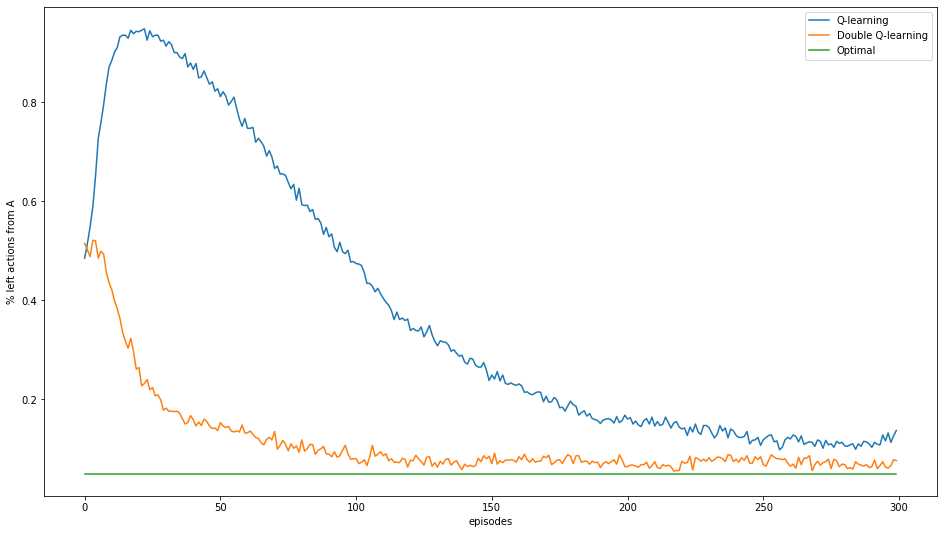

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(left_counts_q, label='Q-learning')
plt.plot(left_counts_double_q, label='Double Q-learning')
plt.plot(np.ones(episodes) * 0.05, label='Optimal')
plt.xlabel('episodes')
plt.ylabel('% left actions from A')
plt.legend()
plt.show()